# **Predicting Delayed Flights**

The file FlightDelays.csv contains information on all commercial flights departing the Washington, DC area and arriving in New York during January 2004. For each flight, there is information on the departure and arrival airports, the distance of the route, the scheduled time and date of the flight, and so on. The variable that we are trying to predict is whether or not a flight is delayed. A delay is defined as an arrival that is at least 15 minutes later than scheduled.
Data Preprocessing. Transform variable day of week (DAY_WEEK) into a categorical variable.
Bin the scheduled departure time into eight bins. Use these and all other columns as predictors (excluding DAY_OF_MONTH). Partition the data into training (60%) and validation (40%) sets. \

a. Fit a classification tree to the flight delay variable using all the relevant predictors. Do not include DEP_TIME (actual departure time) in the model because it is unknown at the time of prediction (unless we are generating our predictions of delays after the plane takes off, which is unlikely). Use a tree with maximum depth 8 and minimum impurity decrease = 0.01.
Express the resulting tree as a set of rules. \

b. If you needed to fly between DCA and EWR on a Monday at 7:00 AM, would you be able to use this tree? What other information would you need? Is it available in practice? What information is redundant? \

c. Fit the same tree as in (a), this time excluding the Weather predictor. Display the resulting tree. \

# **a. Fit a classification tree to the flight delay variable using all the relevant predictors. Do not include DEP_TIME (actual departure time) in the model because it is unknown at the time of prediction (unless we are generating our predictions of delays after the plane takes off, which is unlikely). Use a tree with maximum depth 8 and minimum impurity decrease = 0.01. Express the resulting tree as a set of rules.**

In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\nitis\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

In [3]:
# Load the data
delays_df = pd.read_csv('Datasets/FlightDelays.csv')

In [4]:
# convert variable DAY_WEEK to categorical data type
delays_df['DAY_WEEK'].astype('category')

0       4
1       4
2       4
3       4
4       4
       ..
2196    6
2197    6
2198    6
2199    6
2200    6
Name: DAY_WEEK, Length: 2201, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [5]:
# bin CRS_DEP_TIME variable into 8 bins
delays_df['binned_CRS_DEP_TIME'] = pd.cut(delays_df.CRS_DEP_TIME, 8, labels=False)
delays_df['binned_CRS_DEP_TIME'].astype('category')

0       4
1       5
2       3
3       5
4       2
       ..
2196    0
2197    5
2198    5
2199    3
2200    5
Name: binned_CRS_DEP_TIME, Length: 2201, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [6]:
# remove DAY_OF_MONTH variable
predictors_df = delays_df
columns = list(delays_df.columns)
columns.remove('DAY_OF_MONTH')
predictors_df = predictors_df[columns]

In [7]:
# select only those variables which can be used for predicting the outcome.
# create a new dataframe with predictors
columns = ['CARRIER', 'DEST', 'DISTANCE', 'ORIGIN', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME']
predictors_df = delays_df[columns]

In [8]:
# Displaying the new dataframe
predictors_df.head()

CARRIER DEST  DISTANCE ORIGIN  Weather  DAY_WEEK  binned_CRS_DEP_TIME
0      OH  JFK       184    BWI        0         4                    4
1      DH  JFK       213    DCA        0         4                    5
2      DH  LGA       229    IAD        0         4                    3
3      DH  LGA       229    IAD        0         4                    5
4      DH  LGA       229    IAD        0         4                    2

In [9]:
# List of categorical columns in 'predictors_df'
categorical_columns = ['CARRIER', 'DEST', 'ORIGIN']

In [10]:
# Create dummy variables for categorical columns
predictors_df = pd.get_dummies(predictors_df, columns=categorical_columns, drop_first=True)

In [11]:
# Include the target column in predictors_df
predictors_df['Flight Status'] = delays_df['Flight Status']

In [12]:
# Separate predictors and target variable
X = predictors_df.drop('Flight Status', axis=1)
y = predictors_df['Flight Status']

In [13]:
# Partition the data into training (60%) and validation (40%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

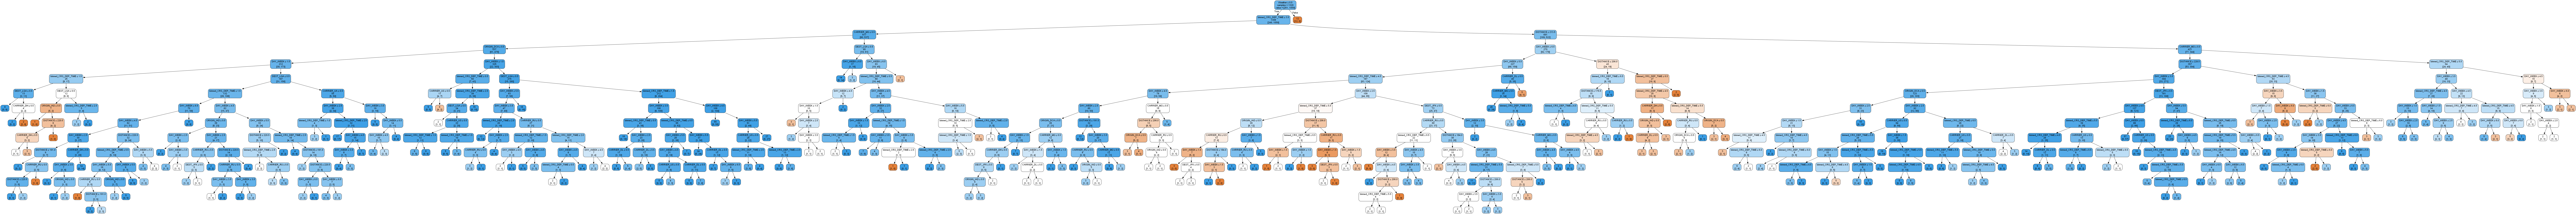

In [14]:
fullclassTree = DecisionTreeClassifier()
fullclassTree.fit(X_train, y_train)
plotDecisionTree(fullclassTree, feature_names=X_train.columns)

In [15]:
predictions = fullclassTree.predict(X_valid)

In [16]:
classificationSummary(y_train, fullclassTree.predict(X_train))
classificationSummary(y_valid, fullclassTree.predict(X_valid))

Confusion Matrix (Accuracy 0.8636)

       Prediction
Actual   0   1
     0 163  98
     1  82 977
Confusion Matrix (Accuracy 0.7264)

       Prediction
Actual   0   1
     0  60 107
     1 134 580


In [17]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_valid,predictions)
tn, fp, fn, tp=conf_matrix.ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(f"sensitivity: {sensitivity}")
print(f"specificity: {specificity}")

sensitivity: 0.8123249299719888
specificity: 0.3592814371257485


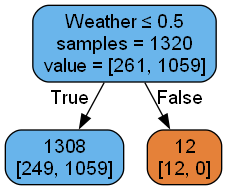

In [18]:
smallClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=20, min_impurity_decrease=0.01)
smallClassTree.fit(X_train, y_train)
plotDecisionTree(smallClassTree, feature_names=X_train.columns)

In [19]:
# Print the tree as a set of rules
from sklearn.tree import export_text
rules = export_text(fullclassTree, feature_names=list(X_train.columns),
                    decimals=3, max_depth=8)
print(rules)


|--- Weather <= 0.500
|   |--- binned_CRS_DEP_TIME <= 3.500
|   |   |--- CARRIER_MQ <= 0.500
|   |   |   |--- ORIGIN_DCA <= 0.500
|   |   |   |   |--- DAY_WEEK <= 1.500
|   |   |   |   |   |--- binned_CRS_DEP_TIME <= 1.500
|   |   |   |   |   |   |--- DEST_LGA <= 0.500
|   |   |   |   |   |   |   |--- class: ontime
|   |   |   |   |   |   |--- DEST_LGA >  0.500
|   |   |   |   |   |   |   |--- CARRIER_DH <= 0.500
|   |   |   |   |   |   |   |   |--- class: ontime
|   |   |   |   |   |   |   |--- CARRIER_DH >  0.500
|   |   |   |   |   |   |   |   |--- class: delayed
|   |   |   |   |   |--- binned_CRS_DEP_TIME >  1.500
|   |   |   |   |   |   |--- DEST_LGA <= 0.500
|   |   |   |   |   |   |   |--- ORIGIN_IAD <= 0.500
|   |   |   |   |   |   |   |   |--- class: delayed
|   |   |   |   |   |   |   |--- ORIGIN_IAD >  0.500
|   |   |   |   |   |   |   |   |--- DISTANCE <= 220.500
|   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |--- DISTA

# **b. If you needed to fly between DCA and EWR on a Monday at 7:00 AM, would you be able to use this tree? What other information would you need? Is it available in practice? What information is redundant?**

If we needed to fly between DCA and EWR on a Monday at 7:00 AM we can use this tree to make predictions by putting the respective values for 'CARRIER', 'DEST', 'DISTANCE', 'ORIGIN', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME'.
However, the Weather information is not readily available in practice but it can be estimated based on weather forecasts closer to the flight date. \
Information that is redundant is the Distance, as it is fixed for a particular route (DCA to EWR) and does not vary between flights on that route.

# **c. Fit the same tree as in a. , this time excluding the Weather predictor. Display the resulting tree.**

In [20]:
#Complete any other necessary steps by adding appropriate coding
# Excluding the 'Weather' predictor
X = X.drop('Weather', axis=1)
print(X.columns)

Index(['DISTANCE', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_DH',
       'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU', 'CARRIER_UA',
       'CARRIER_US', 'DEST_JFK', 'DEST_LGA', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')


In [21]:
# Partition the data into training (60%) and validation (40%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

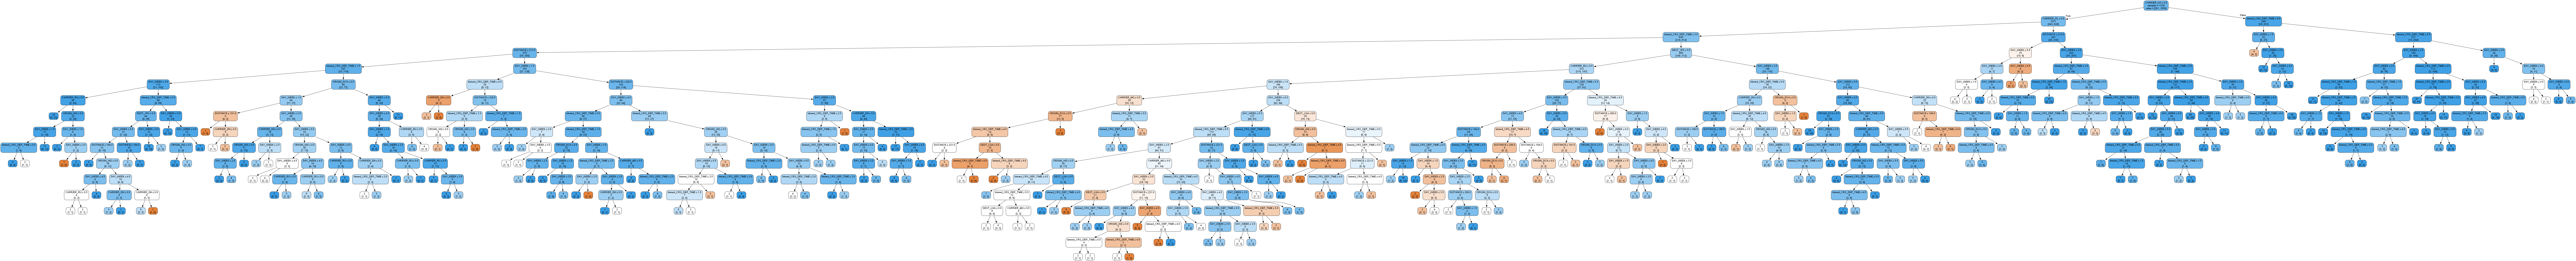

In [22]:
# Fit the same tree as in (a), this time after excluding the Weather predictor
fullclassTree = DecisionTreeClassifier()
fullclassTree.fit(X_train, y_train)
plotDecisionTree(fullclassTree, feature_names=X_train.columns)

In [23]:
predictions = fullclassTree.predict(X_valid)

In [24]:
classificationSummary(y_train, fullclassTree.predict(X_train))
classificationSummary(y_valid, fullclassTree.predict(X_valid))

Confusion Matrix (Accuracy 0.8576)

       Prediction
Actual   0   1
     0 161 100
     1  88 971
Confusion Matrix (Accuracy 0.7106)

       Prediction
Actual   0   1
     0  51 116
     1 139 575


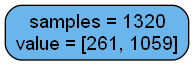

In [25]:
smallClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=20, min_impurity_decrease=0.01)
smallClassTree.fit(X_train, y_train)
plotDecisionTree(smallClassTree, feature_names=X_train.columns)

In [26]:
# Print the tree as a set of rules
from sklearn.tree import export_text
rules = export_text(fullclassTree, feature_names=list(X_train.columns),
                    decimals=3, max_depth=8)
print(rules)


|--- CARRIER_US <= 0.500
|   |--- CARRIER_DL <= 0.500
|   |   |--- binned_CRS_DEP_TIME <= 3.500
|   |   |   |--- DISTANCE <= 213.500
|   |   |   |   |--- binned_CRS_DEP_TIME <= 1.500
|   |   |   |   |   |--- DAY_WEEK <= 3.500
|   |   |   |   |   |   |--- CARRIER_RU <= 0.500
|   |   |   |   |   |   |   |--- class: ontime
|   |   |   |   |   |   |--- CARRIER_RU >  0.500
|   |   |   |   |   |   |   |--- ORIGIN_IAD <= 0.500
|   |   |   |   |   |   |   |   |--- DAY_WEEK <= 1.500
|   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |--- DAY_WEEK >  1.500
|   |   |   |   |   |   |   |   |   |--- class: ontime
|   |   |   |   |   |   |   |--- ORIGIN_IAD >  0.500
|   |   |   |   |   |   |   |   |--- DAY_WEEK <= 1.500
|   |   |   |   |   |   |   |   |   |--- class: ontime
|   |   |   |   |   |   |   |   |--- DAY_WEEK >  1.500
|   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- DAY_WEEK >  3.500
|   |   |   